<a href="https://colab.research.google.com/github/ssv273/Neural_Univesity/blob/main/hw_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса
from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем готовые базы mnist
from tensorflow.keras.callbacks import LambdaCallback

import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import numpy as np # библиотека для работы с массивами данных
import pandas as pd # библиотека для анализа и обработки данных
from PIL import Image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans # Импортируем библиотуке KMeans для кластеризации

import os #
from google.colab import drive #модуль для работы с google диском 
import time, random
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data() # загружаем данные из базы с разбивкой на train/test
xTrainMnist = xTrainMnist.astype('float32')/255 # представляем в виде значений от 0 до 1
xTrainMnist = xTrainMnist.reshape(-1, 28, 28, 1) # меняем форму, приводим к нужным нам размерам
xTestMnist = xTestMnist.astype('float32')/255 # представляем в виде значений от 0 до 1
xTestMnist = xTestMnist.reshape(-1, 28, 28, 1) # меняем форму, приводим к нужным нам размерам

In [3]:
def baseAutoencoder(latent_dim=10, shape=(28,28,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки

    x = Flatten()(x)
    encoded = Dense(latent_dim, activation='relu')(x)   

    input_encoded = Input(shape=(latent_dim,)) # задаем входную размерность

    x = Dense(7*7*64, activation='relu')(input_encoded)  
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 28*20 на 56*40)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    # Сжатие MaxPooling2D не применяем

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 56*40 на 112*80)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    decoded = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    encoder = Model(img_input,encoded)
    decoder = Model(input_encoded, decoded, name="decoder")  
    autoencoder = Model(img_input, decoder(encoder(img_input)), name="autoencoder")

    return encoder, decoder, autoencoder # функция вернёт заданную модель

In [4]:
encoder, decoder, autoencoder = baseAutoencoder() # создаем три сетки с помощью заданной ранее функции


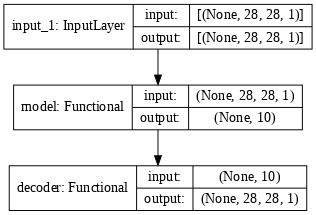

In [5]:
utils.plot_model(autoencoder, show_shapes=True, dpi=70)

In [6]:
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой
EPOCHS = 50

autoencoder.fit(xTrainMnist, xTrainMnist,
                epochs=EPOCHS,
                batch_size=256,
                shuffle=True,
                verbose=1)

Epoch 1/50
235/235 [==============================] - 14s 42ms/step - loss: 0.1196
Epoch 2/50
235/235 [==============================] - 10s 41ms/step - loss: 0.0763
Epoch 3/50
235/235 [==============================] - 10s 41ms/step - loss: 0.0714
Epoch 4/50
235/235 [==============================] - 10s 41ms/step - loss: 0.0693
Epoch 5/50
235/235 [==============================] - 10s 42ms/step - loss: 0.0687
Epoch 6/50
235/235 [==============================] - 10s 42ms/step - loss: 0.0673
Epoch 7/50
235/235 [==============================] - 10s 42ms/step - loss: 0.0657
Epoch 8/50
235/235 [==============================] - 10s 42ms/step - loss: 0.0647
Epoch 9/50
235/235 [==============================] - 10s 42ms/step - loss: 0.0631
Epoch 10/50
235/235 [==============================] - 10s 42ms/step - loss: 0.0615
Epoch 11/50
235/235 [==============================] - 10s 42ms/step - loss: 0.0606
Epoch 12/50
235/235 [==============================] - 10s 42ms/step - loss: 0.0558
E

## Немного порисуем

In [7]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

In [8]:
train_x_flat = xTrainMnist[:200].reshape(-1, 28*28)
train_x_2D = TSNE(n_components=2).fit_transform(train_x_flat)
labels_for_viz = yTrainMnist[:200]

## Посмотрим как располагались вектора в пространстве до энкодинга

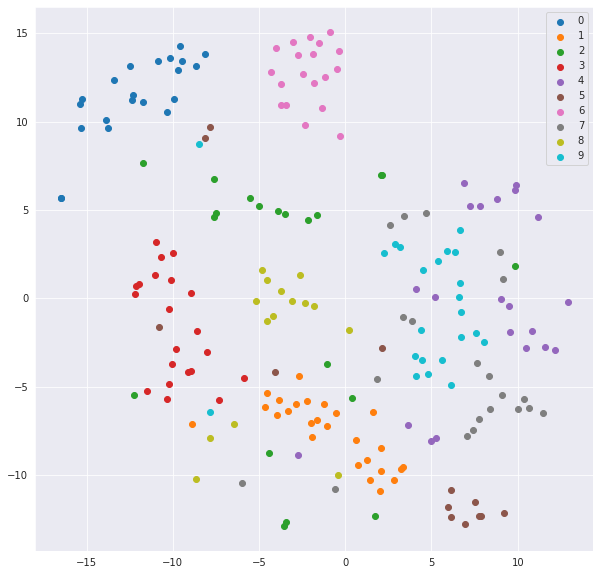

In [9]:
draw_embeddings(train_x_2D, labels_for_viz, list(range(10)))

In [10]:
test_x_flat = encoder.predict(xTestMnist[:200])
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat)
labels_for_viz = yTestMnist[:200]

## После кодирования

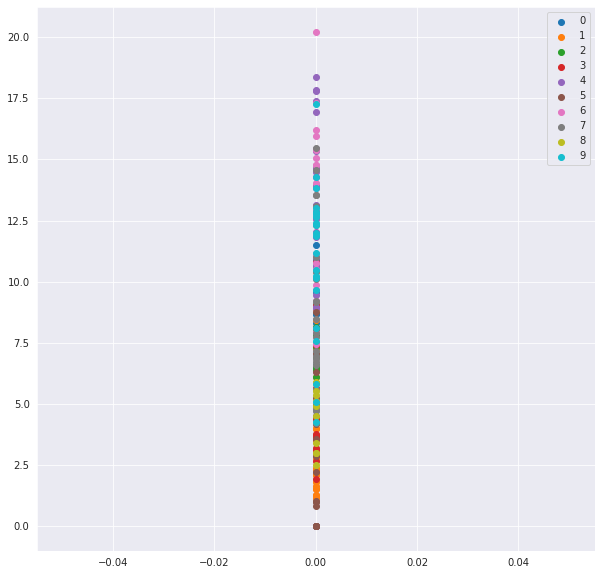

In [11]:
draw_embeddings(test_x_flat, labels_for_viz, list(range(10)))

как мы видим, картинка получилась даже хуже чем была

## Проверим, обучились ли энкодер и декодер

In [12]:
def plotImages(xTrain, pred, shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(14, 7)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [13]:
enc = encoder.predict(xTestMnist[:200])
enc.shape

(200, 10)

In [14]:
dec = decoder.predict(enc)

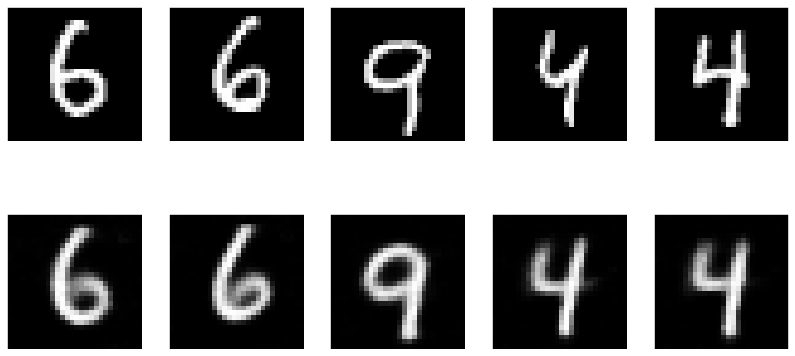

In [15]:
plotImages(xTestMnist[:200], dec, shape=(28,28)) # покажем исходные и восстановленные картинки

как видим - обучились

## Сделаем кластеризацию

In [16]:
x_test_encoded = encoder.predict(xTestMnist)

In [17]:
clustersCount = 10            # Задаем количество кластеров
kmean = KMeans(clustersCount) # Создаем объект KMeans с указанным количеством кластеров
kmean.fit(x_test_encoded)     # Произвдим кластеризацию данных xTrain01Scaled
labels = kmean.labels_        # Получаем метки кластеров

## нарисуем получившиеся кластеры

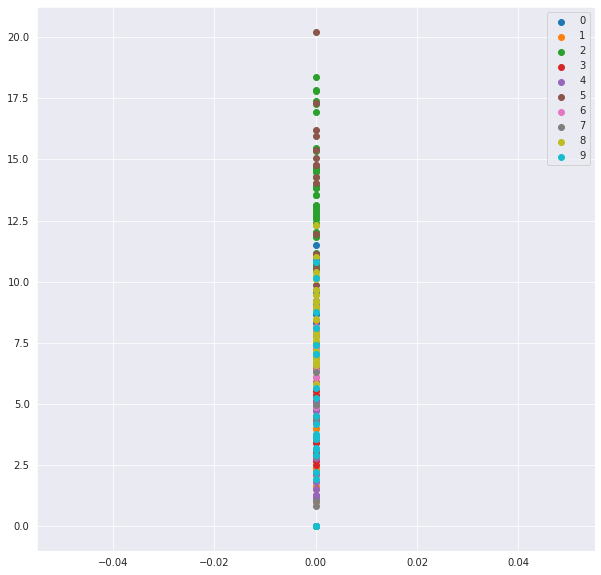

In [18]:
draw_embeddings(x_test_encoded[:200], labels[:200], list(range(10)))

## Посмотрим как удалось кластеризовать

In [19]:
labels_arr = np.array(labels)

In [20]:
for i in range(10):
    count_dict = dict(zip(np.unique(yTestMnist[labels_arr == i], return_counts=True)[0], np.unique(yTestMnist[labels_arr == i], return_counts=True)[1]))
    count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1],reverse=True))
    print(f"""Класс {i}, в классе содержатся следующие цифры {count_dict}""")

Класс 0, в классе содержатся следующие цифры {0: 799, 8: 8, 2: 7, 3: 4, 6: 3, 9: 2, 5: 1}
Класс 1, в классе содержатся следующие цифры {1: 568, 7: 18, 5: 13, 3: 10, 9: 9, 4: 4, 2: 2, 8: 2}
Класс 2, в классе содержатся следующие цифры {4: 546, 9: 417, 7: 134, 2: 27, 8: 9, 3: 7, 5: 5, 6: 2}
Класс 3, в классе содержатся следующие цифры {8: 723, 3: 350, 2: 201, 9: 21, 1: 9, 5: 6, 0: 5, 7: 2, 6: 1}
Класс 4, в классе содержатся следующие цифры {1: 550, 7: 174, 8: 85, 9: 45, 4: 41, 5: 33, 2: 6, 3: 4, 6: 2, 0: 1}
Класс 5, в классе содержатся следующие цифры {6: 837, 2: 16, 0: 12, 4: 9, 5: 7, 3: 3, 9: 2}
Класс 6, в классе содержатся следующие цифры {2: 758, 0: 152, 8: 44, 3: 32, 4: 24, 6: 17, 9: 13, 5: 11, 7: 9, 1: 1}
Класс 7, в классе содержатся следующие цифры {5: 451, 6: 93, 3: 68, 8: 11, 1: 4, 0: 1, 2: 1}
Класс 8, в классе содержатся следующие цифры {7: 691, 9: 492, 4: 358, 8: 19, 2: 14, 3: 12, 1: 1, 5: 1}
Класс 9, в классе содержатся следующие цифры {3: 520, 5: 364, 8: 73, 0: 10, 9: 8, 6: 

## Вывод: как мы видим - качество получилось не очень. Плохо кластеризовались цифры 9, 3, 5, 7. Втдтмо из-за их похожести при написании